# Lab 5

- Data split (Inductive & Transductive)
- Edge prediction
- Hetrogenous graph


In [ ]:
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import TUDataset

pyg_dataset = TUDataset('./enzymes', 'ENZYMES')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)

## Setup

In [ ]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0+cu102


In [ ]:
! pip install torch==1.9.0 torchvision

In [ ]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0+cu102


In [ ]:
!pip install -q torch-scatter # -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse # -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

     |████████████████████████████████| 43 kB 868 kB/s 
     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 407 kB 33.3 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 


# [DeepSNAP](https://github.com/snap-stanford/deepsnap)

- 그래프 러닝을 위한 GNN 훈련 파이프라인 제공합니다.
- 복잡한 그래프 작업을 지원(feature computation, pretraining, subgraph extraction)
- inductive or transductive 환경셋팅 지원(대부분의 패키지에서는 직접 구현해야 함)
- heterogeneous graph를 위한 다양한 기능들 지원(사용할 경우가 많은데도 대부분 패키지에서는 지원기능이 부족)

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

# Data Split in Graphs

## Inductive Split

- Inductive setting: 여러개의 그래프를 훈련셋, 평가셋 (training/valiation and test sets)으로 나눕니다. will split multiple graphs into each .
- graph level task (graph classification etc.) 방식으로 모델 훈련에 사용

In [ ]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name) # from torch_geometric.datasets import Planetoid, TUDataset

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

In [ ]:
# Here we specify the task as graph-level task such as graph classification
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Specify transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

In [ ]:
print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

## Transductive Split

- Transductive setting: 하나의 그래프에서 훈련셋, 평가셋(training /validation / test sets)으로 나눕니다.
- node level task 방식으로 모델 훈련에 사용

In [ ]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

In [ ]:
# Here we specify the task as node-level task such as node classification
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Specify we want the transductive splitting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

In [ ]:
print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# The nodes in each set can be find in node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

# Edge Level Prediction


## Edge Level Split

- Steps:
1. Sample negative edges
2. Split positive edges into different datasets
3. Split training edges into message passing edges and supervision edges
4. Resample the negative edges during the training etc.

*message passing edges: used for GNN message passing

*supervision edges: used in loss function for backpropagation. (supervision edges is not INPUT of GNN).


### All Mode
- `edge_train_mode='all'`:  training supervision edges == message passing edges
- `edge_train_mode='disjoint'`:  training supervision edges != message passing edges

In [ ]:
# Specify task as link_pred for edge-level task
task = 'link_pred'

# Specify the train mode, "all" mode is default for deepsnap dataset
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Transductive link prediction split
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])


In [ ]:
print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

- `edge_label_index`: 훈련할 edge의 인덱스
- `edge_label`: 훈련할 edge의 레이블
- `edge_label` & `edge_label_index`: negative edges가 positive edges와 동일한 비율(default)로 포함됨

In [ ]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Original Cora graph has 5278 edges
Because Cora graph is undirected, the original edge_index has shape torch.Size([2, 10556])
The training set has message passing edge index shape torch.Size([2, 8444])
The training set has supervision edge index shape torch.Size([2, 16888])
The validation set has message passing edge index shape torch.Size([2, 8444])
The validation set has supervision edge index shape torch.Size([2, 2108])
The test set has message passing edge index shape torch.Size([2, 9498])
The test set has supervision edge index shape torch.Size([2, 2116])


In [ ]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Your code here #############
        ## 💬 먼저 이부분을 채워주세요
        ## Note
        ## 1. Initialize the loss function to BCEWithLogitsLoss
        self.loss_fn = nn.BCEWithLogitsLoss()
        ##########################################

        self.dropout = nn.Dropout(dropout)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Your code here #############
        ## 💬 아래의 순서대로 코드를 짜봅시다
        ## 💬 dot product가 기억이 안나는 분들은 실습에서 했던 코드를 생각해봅시다
        ## Note
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product
        x = self.conv1(node_feature, edge_index, )
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)

        source_vs, target_vs = edge_label_index
        similarity = x[source_vs] * x[target_vs]
        pred = torch.sum(similarity, dim=-1)
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [ ]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Your code here #############
            ## 💬 이 부분도 이전 코드와 동일하게 짜주는데, 저희가 GPU를 쓰니까
            ## batch.to(args["device"]) 이런 식으로 필요한 데이터는 GPU에 올려주세요
            ## Note
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters
            optimizer.zero_grad()

            pred = model(batch)
            loss = model.loss_fn(pred, batch.edge_label.type_as(pred))

            loss.backward()
            optimizer.step()
            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0
    num_batches = len(dataloader)
    ############# Your code here #############
    ## 💬 train과 동일한데요. backpropagation 부분을 제외하고
    ## sklearn의 roc_auc_score(label, pred)을 이용해서 ROU-AUC score를 구합니다
    ## 만약 GPU로 올린 변수를 CPU에서 작업하고 싶다면 
    ## pred = pred.detach().cpu().numpy() 
    ## 이런식으로 사용해주세요.
    ## Note
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label
    for i, batch in enumerate(dataloader):
      batch.to(args["device"])
      pred = model(batch)
      pred = torch.sigmoid(pred)
      pred = pred.detach().cpu().numpy()
      label = batch.edge_label.detach().cpu().numpy()
      score += roc_auc_score(label, pred)
    ##########################################
 
    return score / num_batches

In [ ]:
# Please don't change any parameters
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [ ]:
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

# Heterogeneous Graph



## Transform NetworkX graphs to DeepSNAP format

- Heterogenous graphs features:
    * `node_feature`: The feature of each node (`torch.tensor`)
    * `edge_feature`: The feautre of each edge (`torch.tensor`)
    * `node_label`: The label of each node (`int`)
    * `node_type`: The node type of each node (`string`)
    * `edge_type`: The edge type of each edge (`string`)

    * `node_type` & `edge_type`: heterogenous message passing을 담당




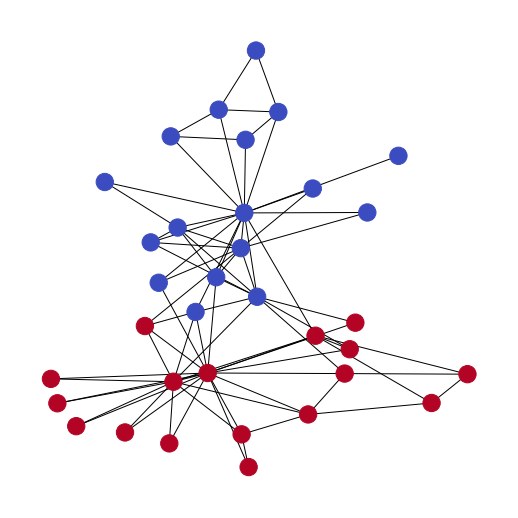

In [ ]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0
  else:
    community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

## Node Type & Node Features

- Node type 
  - "Mr. Hi" "n0"
  - "Officer": "n1"

- Node label 
  - "Mr. Hi" 1
  - "Officer": 1

- Node feature = [1,1,1,1,1] 

In [ ]:
import torch

def assign_node_types(G, community_map):
  ############# Your code here #############
  for vs_id, club in community_map.items():
    G.nodes[vs_id]["node_type"] = "n0" if club == 0 else "n1"
  ##########################################

def assign_node_labels(G, community_map):
  ############# Your code here #############
  for vs_id, club in community_map.items():
    G.nodes[vs_id]["node_label"] = 0 if club == 0 else 1
  ##########################################

def assign_node_features(G):
  ############# Your code here #############
  for vs_id, club in community_map.items():
    G.nodes[vs_id]["_node_feature"] = [1, 1, 1, 1, 1]
  ##########################################

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

- Edge type

  * Edges within club "Mr. Hi": `e0`
  * Edges within club "Officer": `e1`
  * Edges between clubs: `e2`

In [ ]:
def assign_edge_types(G, community_map):
  ############# Your code here ############
  ## 💬 G.edges를 사용하면 그래프의 edge에 접근할 수 있습니다.
  ## community_map을 이용해서 주어진 source node와
  ## target node의 club 정보를 확인하고
  ## 위에서 정의한대로 edge type를 설정해주세요.
  ## G.edges[source_vs, target_vs]['edge_type'] = "e0"
  ## 위의 코드를 사용하면 (source_vs, target_vs) edge의
  ## "edge_type"으로 "e0"을 부여하는 작업을 수행하게됩니다.
  for source_vs, target_vs in G.edges:
    if community_map[source_vs] == community_map[target_vs]:
      if community_map[source_vs] == 0:
        G.edges[source_vs, target_vs]['edge_type'] = "e0"
      else:
        G.edges[source_vs, target_vs]['edge_type'] = "e1"
    else:
      G.edges[source_vs, target_vs]['edge_type'] = "e2"
  #########################################

assign_edge_types(G, community_map)

## Heterogeneous Graph Visualization


In [ ]:
G_orig = copy.deepcopy(G)

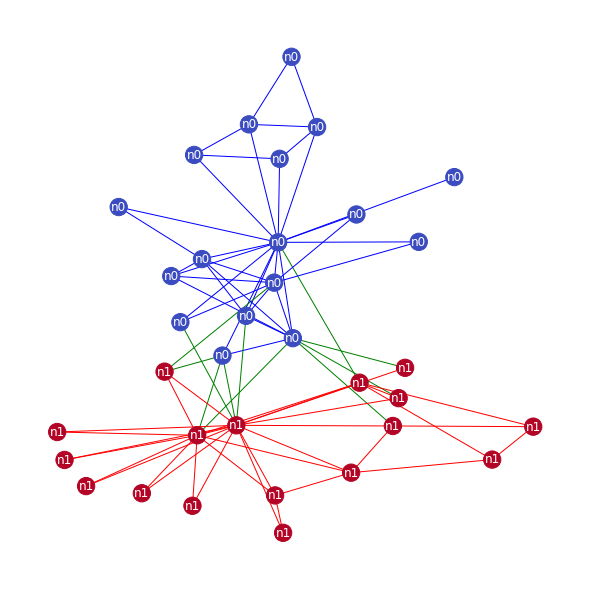

In [ ]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
  # Edges within club "Mr. Hi"
  if community_map[n1] == community_map[n2] and community_map[n1] == 0: 
    edge_color[edge] = 'blue'
  # Edges within club "Officer"
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  # Edges between clubs
  else:
    edge_color[edge] = 'green'


nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

which include edges within each clubs (2 types) and edges across two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

## Transforming to DeepSNAP representation


In [ ]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

In [ ]:
def get_nodes_per_type(hete):
  num_nodes_n0 = len(hete.node_type['n0'])
  num_nodes_n1 = len(hete.node_type['n1'])
  return num_nodes_n0, num_nodes_n1

num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


In [ ]:
def get_num_message_edges(hete):
  message_type_edges = [(message_type, len(edges)) 
    for (message_type, edges) in hete.edge_type.items()]
  return message_type_edges

message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
  print("Message type {} has {} edges".format(message_type, num_edges))


Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


## Dataset Splitting

In [ ]:
dataset = GraphDataset([hete], task='node')

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [ ]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
  for dataset_name, dataset_graphs in datasets.items():
    graph = dataset_graphs[0]
    """
    >> graph.node_label_index
    {'n0': tensor([ 3,  7,  2,  9, 12, 13]),
    'n1': tensor([ 9, 14, 16,  8,  3, 10])}
    """
    graph_node_index = [len(nodes) for node_type, nodes in graph.node_label_index.items()]
    datasets[dataset_name] = sum(graph_node_index)
  return datasets

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
  print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

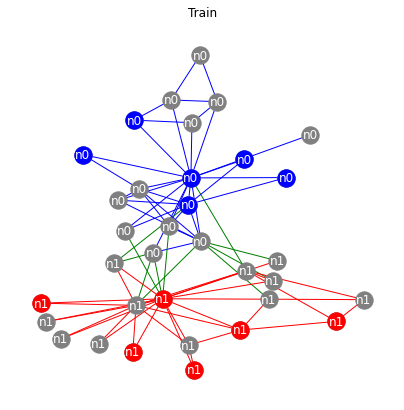

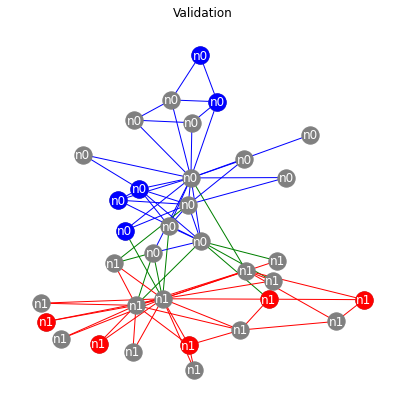

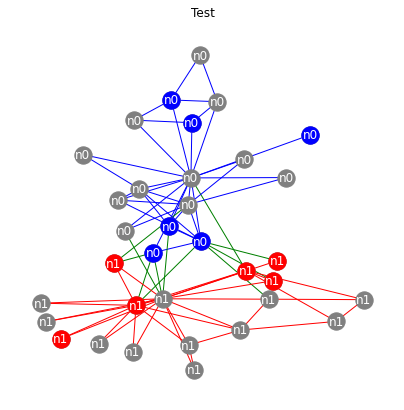

In [ ]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
  n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
  n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

  plt.figure(figsize=(7, 7))
  plt.title(titles[i])
  nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
  nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
  nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
  show()

# Heterogeneous Graph Node Property Prediction



- **Goal**: Implement a GNN model for heterogeneous graph node property prediction (node classification).

- **Example**: Given a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$.

  - $G$ a heterogeneous layer will contains three Heterogeneous GNN layers.
  - In other words, we will use three `HeteroGNNConv` layers.

<br/>
<center>
<img src="https://web.stanford.edu/class/cs224w/images/colab4/hetero_conv.png"/>
</center>
<br/>

  - In our code, all the $l^{th}$ Heterogeneous GNN layers will be managed by a ($l^{th}$) Heterogeneous GNN Wrapper layer (the `HeteroGNNWrapperConv`). 

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>

- **Implement steps:**

1. Implement the `HeteroGNNConv` first.
2. Implement the `mean` aggregation in `HeteroGNNWrapperConv`.
3. Implement the `generate_convs`.
4. Implement the `HeteroGNN` model and the `train` function.
5. Train the model with `mean` aggregation across the message types and make sure your model has reasonable performance.
6. Implement the `attn` aggregation in `HeteroGNNWrapperConv`.
7. Train the model with `attn` aggregation across the message types and make sure your model has reasonable performance.

## Setup

In [ ]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Dataset: ACM Citation Network



In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('acm.pkl')

## Heterogeneous GNN Layer: **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216))

- For each message type, $m =(s, r, d)$, we implement the GNN layer, where each message type is a tuple containing three elements where $s$ refers to the source node type, $r$ refers to the edge (relation) type and $d$ refers to the destination node type.

- The update rule is described as below:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where $[m]$ indicates that the weight matrices or embeddings with respect to message type $m$, $W_s^{(l)[m]}$ computes the messages from neighboring nodes, $W_d^{(l)[m]}$ compute messages from the node itself, and $W^{(l)[m]}$ aggregates messages from both node types. In the equation above, $v$ has the node type $d$, and $u$ has the node type $s$.

- The aggregate function is applied as follows:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [ ]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_dst = nn.Linear(self.in_channels_dst, self.out_channels)
        self.lin_src = nn.Linear(self.in_channels_src, self.out_channels)
        self.lin_update = nn.Linear(self.out_channels * 2, self.out_channels)

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None,
        res_n_id=None,
    ):
        ############# Your code here ############
        return self.propagate(edge_index, size=size, 
        node_feature_src=node_feature_src, 
        node_feature_dst=node_feature_dst, 
        res_n_id=res_n_id)
        ##########################################

    def message_and_aggregate(self, edge_index, node_feature_src):
        ############# Your code here ############
        """
        :param edge_index (torch_sparse.SparseTensor - more efficient)
        *document. https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        """
        return matmul(edge_index, node_feature_src, reduce='mean')
        ##########################################

    def update(self, aggr_out, node_feature_dst, res_n_id):
        ############# Your code here ############
        node_feature_dst = self.lin_dst(node_feature_dst)
        aggr_out = self.lin_src(aggr_out)
        concat_out = torch.cat((node_feature_dst, aggr_out), dim=-1)
        aggr_out = self.lin_update(concat_out)
        return aggr_out
        ##########################################

## Heterogeneous GNN Wrapper Layer

- The basic aggregate function is applied as below:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]},
\end{equation}

where node $v$ has the node type $d$ and $M$ is the total number of message types that the destination node type is $d$.

- The semantic level attention aggregate function, introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)):

  - Instead of directly averaging on the message type aggregation results, we use attention to learn which message type result can be more important, then aggregate from all the message types. Following are the equations for semantic level attention:

  \begin{equation}
  e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big),
  \end{equation}
  where $q_{attn}$ is a semantic-
level attention vector, $m$ refers to message type and $d$ refers to the destination node type. 
  - Then we can compute the attention and update the $h_v^{(l)}$:

  \begin{equation}
  \alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
  \end{equation}

  \begin{equation}
  h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
  \end{equation}

In [ ]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
          self.attn_proj = nn.Sequential(
              nn.Linear(args['hidden_size'], args['attn_size']),
              nn.Tanh(),
              nn.Linear(args['attn_size'], 1, bias=False), # q_semantic_attention
          )

    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}        
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        """
        :param xs is a list of tensors (embeddings) with respect to message 
        type aggregation results.
        """
        if self.aggr == "mean":
            ############# Your code here ############
            out = torch.mean(torch.stack(xs), dim=0)
            return out
            ##########################################

        elif self.aggr == "attn":
            ############# Your code here ############
            # compute the attention 
            x = self.attn_proj(torch.stack(xs, dim=0))
            x = torch.mean(x, dim=1)

            self.alpha = torch.softmax(x, dim=0)
            self.alpha = self.alpha.detach()

            # apply the attention and update the h
            out = torch.stack(xs, dim=0)
            out = self.alpha.unsqueeze(-1) * out

            out = torch.sum(out, dim=0)
            return out
            ##########################################

## Initialize Heterogeneous GNN Layers
- We create a dictionary of `HeteroGNNConv` layers where the keys are message types.



In [ ]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    convs = {}
    ############# Your code here ############
    for m in hetero_graph.message_types: # get all message types
        if first_layer: # in_channel_size = node_feature_size
            num_node_feat_src = hetero_graph.num_node_features(m[0])
            num_node_feat_dst = hetero_graph.num_node_features(m[-1])
            convs[m] = conv(num_node_feat_src, num_node_feat_dst,
                                   hidden_size)
        else: # in_channel_size = hidden_size
            convs[m] = conv(hidden_size, hidden_size, hidden_size)
    ##########################################
    return convs

## HeteroGNN

- Our model is optimized as follows:

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.post_mps}$

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()
        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        ############# Your code here #############
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ## pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1.0).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer 
        ## where the `out_features` is the number of classes for that node type.
        convs1 = generate_convs(
            hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(
            hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False)

        self.convs1 = HeteroGNNWrapperConv(convs1, args, self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, self.aggr)

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()
        
        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1.0)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1.0) 
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()
            num_labels = hetero_graph.num_node_labels(node_type)
            self.post_mps[node_type] = nn.Linear(self.hidden_size, num_labels)
        ##########################################

    def forward(self, node_feature, edge_index):
        """
        :param node_feature: a dictionary of tensors where keys are node types 
        and values are corresponding feature tensors.
        :param edge_index: a dictionary of tensors where keys are message types 
        and values are corresponding edge index tensors (with respect to 
        each message type).

        *For heterogeneous graph, we use deepsnap.hetero_gnn.forward_op
        *Given a dictionary input x, it will return a dictionary with the same 
        keys and the values applied by the corresponding values of the 
        module_dict with specified parameters. 
        The keys in x are same with the keys in the module_dict.
        *Document: https://snap.stanford.edu/deepsnap/modules/hetero_gnn.html?highlight=deepsnap%20hetero_gnn%20forward_op#deepsnap.hetero_gnn.forward_op
        edge index tensors (with respect to each message type).
        """
        x = node_feature

        ############# Your code here #############
        ## 💬 모델의 순서를 따라서 작성해줍니다
        ## self.convs1 -> self.bns1 -> self.relus1
        ## -> self.convs2 -> self.bns2 -> self.relus2
        ## -> post_mps

        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)

        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)

        x = forward_op(x, self.post_mps)
        ##########################################
        
        return x

    def loss(self, preds, y, indices):
        
        loss = 0
        loss_func = F.cross_entropy

        for node_type in preds:
            idx = indices[node_type]
            pred = preds[node_type][idx]
            loss += loss_func(pred, y[node_type][idx])

        return loss

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.

**Please do not modify other parts in `train` and `test` for grading purposes.**

In [ ]:
def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)
    loss = model.loss(preds, hetero_graph.node_label, train_idx)

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0):
    model.eval()
    accs = []
    for index in indices:
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))
    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [ ]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Dataset and Preprocessing

In the next, we will load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.

We will use the `ACM(3025)` dataset in our node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and our dataset is extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in our heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [ ]:
print("Device: {}".format(args['device']))

# Load the data
data = torch.load("acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cpu
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991]),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022]),
             size=(3025, 3025), nnz=2207736, density=24.13%)


## Start Training!

Now lets start training!

## Training the Mean Aggregation

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

pbar = tqdm(range(args['epochs']))
for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    pbar.set_description(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, " +
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, " +
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, " +
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
    pbar.update()
pbar.close()

best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

  0%|          | 0/100 [00:00<?, ?it/s]

## Training the Attention Aggregation

In [ ]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

pbar = tqdm(range(args['epochs']))
for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    pbar.set_description(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, " +
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, " +
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, " +
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
    pbar.update()
pbar.close()
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

## Attention for each Message Type

Through message type level attention we can learn that which message type is more important to which layer.

Here we will print out and show that each layer pay how much attention on each message type.

In [ ]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx].item():.4f} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx].item():.4f} on message type {message_type}")

Layer 1 has attention 0.5550 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.4450 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.4944 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.5056 on message type ('paper', 'subject', 'paper')
